# Fairness by Gender

This is the third in a series of notebooks that make up a [case study on classification and algorithmic fairness](https://allendowney.github.io/RecidivismCaseStudy/).
This case study is part of the [*Elements of Data Science*](https://allendowney.github.io/ElementsOfDataScience/) curriculum.
[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/RecidivismCaseStudy/blob/v1/03_fairness.ipynb).

The goal of this case study is to explain the statistical arguments presented in two articles from 2016:

* "[Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)", by Julia Angwin, Jeff Larson, Surya Mattu and Lauren Kirchner, and published by [ProPublica](https://www.propublica.org).

* A response by Sam Corbett-Davies, Emma Pierson, Avi Feller and Sharad Goel: "[A computer program used for bail and sentencing decisions was labeled biased against blacks. It’s actually not that clear.](https://www.washingtonpost.com/news/monkey-cage/wp/2016/10/17/can-an-algorithm-be-racist-our-analysis-is-more-cautious-than-propublicas/)", published in the Washington Post.

I encourage you to read both articles before you go on.
Both are about COMPAS, a statistical tool used in the justice system to assign defendants a "risk score" that is intended to reflect the risk that they will commit another crime if released.

The ProPublica article evaluates COMPAS as a binary classifier, and compares its error rates for black and white defendants.
In response, the Washington Post article shows that COMPAS has the same predictive value black and white defendants.  And they explain that the test cannot have the same predictive value and the same error rates at the same time.

[In the first notebook](https://colab.research.google.com/github/AllenDowney/RecidivismCaseStudy/blob/v1/01_classification.ipynb) I replicated the analysis from the ProPublica article.

[In the second notebook](https://colab.research.google.com/github/AllenDowney/RecidivismCaseStudy/blob/v1/02_calibration.ipynb) I replicated the analysis from the WaPo article.

In this notebook I apply the same analysis to evaluate the performance of COMPAS for male and female defendants.

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://raw.githubusercontent.com/AllenDowney/RecidivismCaseStudy/v1/rcs_utils.py"
)

<IPython.core.display.Javascript object>

## Data

The authors of "Machine Bias" published their data and analysis in [this repository](https://github.com/propublica/compas-analysis).
The terms of use for the data [are here](https://www.propublica.org/datastore/terms).  In compliance with those terms, I am not redistributing the data.  The following cell downloads the data file we'll use directly from their repository.

In [2]:
download(
    "https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv"
)

<IPython.core.display.Javascript object>

The following cell reads the data file:

In [3]:
import pandas as pd

cp = pd.read_csv("compas-scores-two-years.csv")
cp.shape

(7214, 53)

<IPython.core.display.Javascript object>

[**Note:** I wrote about data bias in the previous notebook, but I am repeating it here in case someone reads this notebook without reading the previous one.]

Systems like COMPAS are trying to predict whether a defendant will *commit* another crime if released.  But the dataset reports whether a defendant was *charged* with another crime.

Not everyone who commits a crime gets charged (not even close).  The probability of getting charged for a particular crime depends on the type of crime and location; the presence of witnesses and their willingness to work with police; the decisions of police about where to patrol, what crimes to investigate, and who to arrest; and decisions of prosecutors about who to charge.

It is likely that every one of these factors depends on the race of the defendant.  In this dataset, the prevalence of *new charges* is higher for black defendants, but that doesn't necessarily mean that the prevalence of *new crimes* is higher.  

If the dataset is affected by racial bias in the probability of being charged, prediction algorithms like COMPAS will be biased, too.  In discussions of whether and how these systems should be used in the criminal justice system, this is an important issue.  

However, I am going to put it aside *for now* in order to focus on understanding the arguments posed in the ProPublica article and the metrics they are based on.  For the rest of this notebook I will take the "recidivism rates" in the dataset at face value; but I will try to be clear about that they mean (and don't mean).

## Male and female defendants

The authors of the ProPublica article published a supplementary article,
[*How We Analyzed the COMPAS Recidivism Algorithm*](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm), which describes their analysis in more detail.

In the supplementary article, they briefly mention results for male and female respondents:

> The COMPAS system unevenly predicts recidivism between genders. According to Kaplan-Meier estimates, women rated high risk recidivated at a 47.5 percent rate during two years after they were scored. But men rated high risk recidivated at a much higher rate – 61.2 percent – over the same time period. This means that a high-risk woman has a much lower risk of recidivating than a high-risk man, a fact that may be overlooked by law enforcement officials interpreting the score.

We can replicate this result using the methods from the previous notebooks; we don't have to do Kaplan-Meier estimation.

According to the binary gender classification in this dataset, about 81% of defendants are male.

In [4]:
male = cp["sex"] == "Male"
male.mean()

0.8066260049902967

<IPython.core.display.Javascript object>

In [5]:
female = cp["sex"] == "Female"
female.mean()

0.19337399500970334

<IPython.core.display.Javascript object>

Here are the confusion matrices for male and female defendants.

In [6]:
from rcs_utils import make_matrix

matrix_male = make_matrix(cp[male])
matrix_male

,Pred Positive,Pred Negative
Actual,,
Positive,1732,1021
Negative,994,2072


<IPython.core.display.Javascript object>

In [7]:
matrix_female = make_matrix(cp[female])
matrix_female

,Pred Positive,Pred Negative
Actual,,
Positive,303,195
Negative,288,609


<IPython.core.display.Javascript object>

And here are the metrics:

In [8]:
from rcs_utils import compute_metrics

metrics_male = compute_metrics(matrix_male, "Male defendants")
metrics_male

,Percent
Male defendants,
FPR,32.4
FNR,37.1
PPV,63.5
NPV,67.0
Prevalence,47.3


<IPython.core.display.Javascript object>

In [9]:
metrics_female = compute_metrics(matrix_female, "Female defendants")
metrics_female

,Percent
Female defendants,
FPR,32.1
FNR,39.2
PPV,51.3
NPV,75.7
Prevalence,35.7


<IPython.core.display.Javascript object>

The fraction of defendants charged with another crime (prevalence) is substantially higher for male defendants (47% vs 36%).

Nevertheless, the error rates for the two groups are about the same.

As a result, the predictive values for the two groups are substantially different:

* PPV: Women classified as high risk are less likely to be charged with another crime, compared to high-risk men (51% vs 64%).

* NPV: Women classified as low risk are more likely to "survive" two years without a new charge, compared to low-risk men (76% vs 67%).

The difference in predictive values implies that COMPAS is not calibrated for men and women.  In the next section we'll campare the calibration curves.

## Calibration for male and female defendants

Here are the calibration curves for male and female defendants.

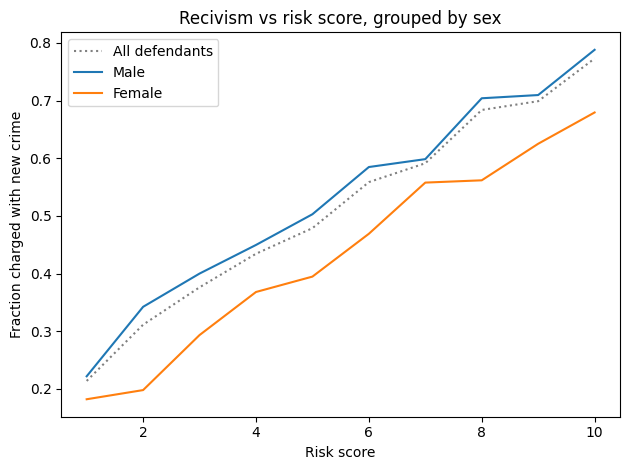

<IPython.core.display.Javascript object>

In [10]:
import matplotlib.pyplot as plt
from rcs_utils import calibration_curve, decorate

cal_all = calibration_curve(cp)
cal_all.plot(linestyle="dotted", color="gray", label="All defendants")

cal_male = calibration_curve(cp[male])
cal_male.plot(label="Male")

cal_female = calibration_curve(cp[female])
cal_female.plot(label="Female")

decorate(
    xlabel="Risk score",
    ylabel="Fraction charged with new crime",
    title="Recivism vs risk score, grouped by sex",
)

For all risk scores, female defendants are substantially less likely to be charged with another crime.

Or, reading the graph the other way, female defendants are given risk scores 1-2 points higher than male defendants with the same actual risk of recidivism.

To the degree that COMPAS scores are used to decide which defendants are incarcerated, those decisions:

* Are unfair to women.

* Are less effective than they could be, if they incarcerate lower-risk women while allowing higher-risk men to go free.


## What would it take?

Suppose we want to fix COMPAS so that predictive values are the same for male and female defendants.  We could do that by using different thresholds for the two groups.

In this section, we'll see what it would take to re-calibrate COMPAS; then we'll find out what effect that would have on error rates. 

From the previous notebook, `sweep_threshold` loops through possible thresholds, makes the confusion matrix for each threshold, and computes the accuracy metrics.

Here are the resulting tables for all defendants, male defendants, and female defendants.

In [11]:
from rcs_utils import sweep_threshold

table_all = sweep_threshold(cp)

<IPython.core.display.Javascript object>

In [12]:
table_male = sweep_threshold(cp[male])

<IPython.core.display.Javascript object>

In [13]:
table_female = sweep_threshold(cp[female])

<IPython.core.display.Javascript object>

As we did in the previous notebook, we can find the threshold that would make predictive value the same for both groups.

In [14]:
from rcs_utils import predictive_value

matrix_all = make_matrix(cp)
ppv, npv = predictive_value(matrix_all)

<IPython.core.display.Javascript object>

In [15]:
from rcs_utils import crossing

crossing(table_male["PPV"], ppv)

array(3.36782883)

<IPython.core.display.Javascript object>

In [16]:
crossing(table_male["NPV"], npv)

array(3.40116329)

<IPython.core.display.Javascript object>

With a threshold near 3.4, male defendants would have the same predictive values as the general population.

Now let's do the same computation for female defendants.

In [17]:
crossing(table_female["PPV"], ppv)

array(6.88124668)

<IPython.core.display.Javascript object>

In [18]:
crossing(table_female["NPV"], npv)

array(6.82760429)

<IPython.core.display.Javascript object>

To get the same predictive values for men and women, we would need substantially different thresholds: about 6.8 compared to 3.4.

At those levels, the false positive rates would be very different:

In [19]:
from rcs_utils import interpolate

interpolate(table_male["FPR"], 3.4)

array(39.12)

<IPython.core.display.Javascript object>

In [20]:
interpolate(table_female["FPR"], 6.8)

array(9.14)

<IPython.core.display.Javascript object>

And so would the false negative rates.

In [21]:
interpolate(table_male["FNR"], 3.4)

array(30.98)

<IPython.core.display.Javascript object>

In [22]:
interpolate(table_female["FNR"], 6.8)

array(74.18)

<IPython.core.display.Javascript object>

If the test is calibrated in terms of predictive value, it is uncalibrated in terms of error rates.

## ROC

In the previous notebook I defined the [receiver operating characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

The following figure shows ROC curves for male and female defendants:

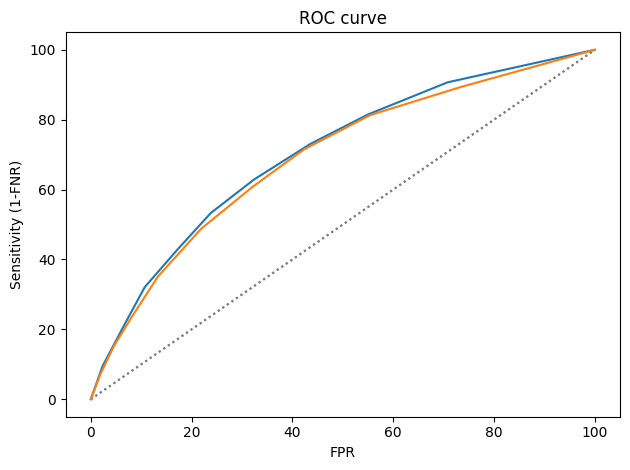

<IPython.core.display.Javascript object>

In [23]:
from rcs_utils import plot_roc

plot_roc(table_male)
plot_roc(table_female)

The ROC curves are nearly identical, which implies that it is possible to calibrate COMPAS equally for male and female defendants.

## AUC

In the previous notebook I define [concordance](https://cran.r-project.org/web/packages/survival/vignettes/concordance.pdf) and compute it by estimating the area under the ROC curve.

The concordance (AUC) for all respondents is about 70%.

In [24]:
from rcs_utils import compute_auc

compute_auc(table_all)

0.7061166121516749

<IPython.core.display.Javascript object>

For the subgroups it is slightly lower, but also near 70%.

In [25]:
compute_auc(table_male)

0.7078737271757202

<IPython.core.display.Javascript object>

In [26]:
compute_auc(table_female)

0.6926061491859792

<IPython.core.display.Javascript object>

Again, this implies that COMPAS could be calibrated.

## Summary

With respect to sex, COMPAS is fair by the criteria posed by the ProPublica article: it has the same error rates for groups with different prevalence.

But it is unfair by the criteria of the WaPo article, which argues:

> A risk score of seven for black defendants should mean the same thing as a score of seven for white defendants. Imagine if that were not so, and we systematically assigned whites higher risk scores than equally risky black defendants with the goal of mitigating ProPublica’s criticism. We would consider that a violation of the fundamental tenet of equal treatment.

With respect to male and female defendants, COMPAS violates this tenet.

So who's right?  We have two competing definitions of fairness, and it is mathematically impossible to satisfy them both.  Is it better to have equal error rates for all groups, as COMPAS does for men and women?  Or is it better to be calibrated, which implies equal predictive values?  Or, since we can't have both, should the test be "tempered", allowing both error rates and predictive values to depend on prevalence?

[In the next notebook](https://colab.research.google.com/github/AllenDowney/RecidivismCaseStudy/blob/v1/04_matrix.ipynb) I explore these trade-offs in more detail.

Recidivism Case Study

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)